#**Deep Learning with Pytorch**

## Table of Contents
1. Data Preprocessing
    + Dataset class, Transforms, DataLoader, Data visualization in PyTorch
2. Task 1) Implement and train a deep neural network using PyTorch
    + Build a Deep Neural Network using PyTorch
    + Model training through loss calculation and backpropagation
    + Measure the performance of the trained model
    + Plotting the results
3. Task 2) Implement and train a deep neural network with more layers

4. Optional Tasks
    + Use different optimizers (e.g., SGD with momentum, Adam) and check the results
    + Preventing Overfit: Regularization Techniques
    + Applying Batch Normalization
    
5. Reference


##**1. Data Loading**
- To load your datasets smoothly, first you need to be familiar with `Dataset Class`, `Transforms`, `DataLoader` in PyTorch.



**1) Dataset Class**
- `Dataset Class` is an abstract class representing a dataset. It should have the following methods:
 - __ len __ so that `len(dataset)` returns the size of the dataset.
 - __ getitem __ to support the indexing so that `dataset[i]` returns $i$-th sample.

**2) Transforms**
- Most neural networks expect the images of a fixed size. But the samples from our dataset are often not of the same size. Therefore, we need to preprocess our data sample.
- Here, we introduce some basic transforms :
 - `ToTensor` : to convert the numpy images to torch images (Note that this is essential for implementing the network in pytorch.)
 - `Resize`: to resize the input PIL Image to the given size (It's useful when the image size is different)
 - `Normalize` : to normalize a tensor image with specific mean and standard deviation
  - `RandomCrop` : to crop from image randomly. This is a data augementation.

PyTorch provides a package called torchvision that has data loaders for common datasets such as Imagenet, CIFAR10, MNIST, etc. and data transformers.

Now, let's load MNIST datasets which we are going to use in today's lecture.

MNIST dataset is a dataset of 28 $*$ 28 pixel grayscale images of handwritten single digits between 0 and 9.

In [ ]:
import torch
from torchvision import datasets, transforms

train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True) # The output of torchvision datasets are PILImage images of range [0,1]. We transforms them to Tensors of normalized range [-1,1] Using ToTensor()
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!



/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:469: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


You can check the size of training and test dataset

In [ ]:
print('\nThe size of training dataset :', len(train_dataset))
print('\nThe size of test dataset :', len(test_dataset))


The size of training dataset : 60000

The size of test dataset : 10000


**3) DataLoader**

-  We are losing a lot of features by using a simple `for` loop to iterate over the data(full batch). So, in practice, we use a part of the entire samples(called the batch) to obtain a gradient of a cost fucntion (in other words, to implement stochastic gradient descent). To this end, we need to batch and shuffle the data and these are conducted by `DataLoader` in PyTorch


In [ ]:
batch_size = 64 # Set the batch size you want

train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) # Shuffle argument controls data shuffling for stochastic gradient descent
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Usually used as follows.
for (images, labels) in train_loader:
    print(images.shape)
    print(labels.shape)
    ####################
    #    statements  
    ####################
    break 

torch.Size([64, 1, 28, 28])
torch.Size([64])


4) Data Visualization
- We can visualize our input images. It can be implemented by the following code.

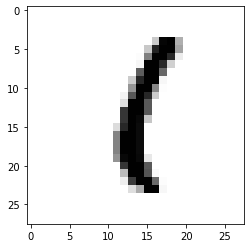

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torchvision

dataiter = iter(train_loader)
inputs, labels = dataiter.next()

figure = plt.figure()
plt.imshow(inputs[0].numpy().squeeze(), cmap='gray_r') # We can see a first image of a batch
plt.show()

## **Task 1) Implement and train a deep neural network using PyTorch**

### **1. Defining our Model**

- In this practice session, we will build a small MLP(only consists of Fully-Connected Layers) model. 
- As you learned in the last lecture, an linear operation is computed in the Fully-Connected Layer which means the following :

 $\mathbf{Y} = \mathbf{X}\mathbf{W} + \mathbf{b}$ where $\mathbf{W} \in \mathbf{R}^{ \ previous\_layer\_size \times next\_layer\_size}$ and $\mathbf{b}$ $\in \mathbf{R}^{next\_layer\_size}$

- And then, after passing through the linear layer, activation function (e.g., ReLU) is applied to give non-linearity except for the output layer. In the output layer, Softmax function is used for multi-class classification.

 ReLU(x) = max(0,x)

 $\tilde{y}_{i}$ = $[Softmax(x)]_i$ = $\frac{e^{x_i}}{\sum_{j=1}^{C}e^{x_k}}$ where $x = [x_1, x_2, \ldots, x_C]$ and C is the number of classes

Let's make a model with 3 layers (2 hidden layers).

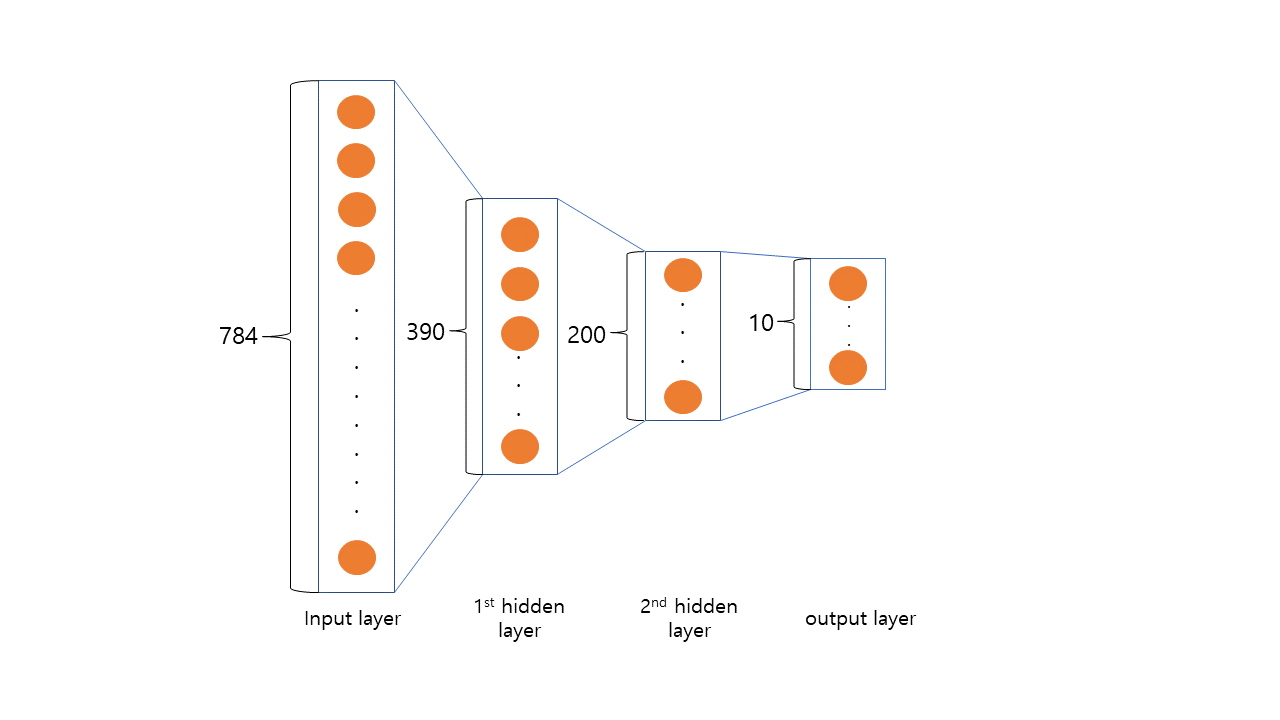

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Mynetwork(nn.Module):

    def __init__(self):

        super(Mynetwork, self).__init__()
        # torch.nn.Linear(size of each input sample, size of each output sample)
        self.fc1 = nn.Linear(784,390) # Input size should be 784 (28*28*1) and output size is the size of first hidden layer(your design parameter).
        self.fc2 = nn.Linear(390, 200) # Input size should be the size of first hidden layer and output size is the size of second hidden layer(your design parameter).
        self.fc3 = nn.Linear(200, 10) # Input size should be the size of second hidden layer and output size should be 10 (the number of classes).
        
    def forward(self, x):

        x = x.view(-1, 1*28*28) # Change the shape([batch_size, channels, row, col]) to [batch_size, channels*row*col] for fully-connected layer
        x = F.relu(self.fc1(x)) # Use relu function after fully-connected layer
        x = F.relu(self.fc2(x))
        x = self.fc3(x) # Note that softmax function is not applied here.

        return x

Then, let's check our model.

In [ ]:
model = Mynetwork()
input_test = torch.randn(64,1,28,28)  # shape: [batch_size, channels, row, col]
output = model(input_test)  # output shape: [batch_size, the number of classes]
print(output.size())

torch.Size([64, 10])


### **2. Training and Evaluation**
**Training** : Once the data is loaded and the model is defined, we can train the deep neural network.
- Set parameters for training,
    - Epoch, optimizer, learning rate and loss function
- 1) Pass the input through the model to get the output (forward propagation)
```python
    outputs = model(inputs) 
```
- 2) Compute loss using the obtained output and true label
```python
    loss = criterion(outputs, labels) 
```
- 3) Obtain the gradient of each parameters by implementing backpropagation
```python
    loss.backward() 
```
- 4) Perform a parameters update via optimizer using the computed gradient 
```python
     optimizer.step() 
```

**Evaluation** : After finishing training, we calculate accuracy of the test data to measure the performance of the models we obtained through training.



Before training, load the data and define the model again.

In [ ]:
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import torchvision

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from torchvision import datasets, transforms
import torch.optim as optim

from tqdm import tqdm

################## Load data and define a model ##################

# MNIST dataset load
train_dataset = datasets.MNIST(root='./data', train=True, transform=transforms.ToTensor(), download=True) # The output of torchvision datasets are PILImage images of range [0,1]. We transforms them to Tensors of normalized range [-1,1] Using ToTensor()
test_dataset = datasets.MNIST(root='./data', train=False, transform=transforms.ToTensor(), download=True)


batch_size = 64 # Set the batch size you want

#Make train and test loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True) # Shuffle argument controls data shuffling for stochastic gradient descent
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

device = 'cuda' if torch.cuda.is_available() else 'cpu' #If we can use gpu, return 'cuda'

#Make a model defined above
model1 = Mynetwork()
model1.to(device) # Move our model to gpu if we can use gpu



Mynetwork(
  (fc1): Linear(in_features=784, out_features=390, bias=True)
  (fc2): Linear(in_features=390, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=10, bias=True)
)

**1) Set parameters for training**
- For multiclass classification, we use the cross entropy loss $L = -\sum_{i=1}^{C}t_ilog(y_i)$ where $t$ is indicates a label of one-hot vector type (i.e. if true label is 4, t=[0,0,0,1,0,0,0,0,0,0]. Thus $t_4$=1 and if i is not 4, $t_i$=0)

- In PyTorch, we can update the parameters of model via optimizer. Here, we use simple SGD as optimizer. 
- But you can use the other optimizers (e.g., SGD with momentum and Adam). This will be done in task3. 

In [ ]:
#Set the epoch
num_epoch = 15

#Determine the type of loss
criterion = nn.CrossEntropyLoss()

#Choose an optimizer for you to use and set learning rate
optimizer = optim.SGD(model1.parameters(), lr=0.001)

**2) Training**
- Based on the above, the training is implemented by below function.

In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    
    # The layers of our model which uses dropout, batch-normalization should behave differently depending on the current phase(training or evaluation)
    model.train() # training mode 
    
    losses_batch = []

    for idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) #Move data to gpu if we can use gpu
        optimizer.zero_grad() # clear out the gradients to avoid accumulating with the gradients computed in previous step. 
        outputs = model(inputs) # 1) Proceed forward pass
        loss = criterion(outputs, labels) # 2) Compute the loss by comparing the predictive outputs and the actual labels
        losses_batch.append(loss)
        loss.backward() # 3) Compute a gradient of a loss function by backpropagation
        optimizer.step() # 4) Update the weight by gradient descent according to the method(SGD or SGD with momentum or Adam) we defined earlier

    loss_epoch = sum(losses_batch)/len(losses_batch)

    return loss_epoch

**3) Evaluation**
- Based on the above, the evaluation is implemented by below function.

In [ ]:
######### Evaluation ###########

def eval(model, device, test_loader):
     
    model.eval() # evaluation mode
    total = 0
    correct = 0

    with torch.no_grad(): # Deactivate the autograd engine # Note that in testing time, we don't need the gradient.
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device) #Move data to gpu if we can use gpu
            outputs = model(inputs) # Obtain the outputs from model
            _, predicts = torch.max(outputs.data , 1) # Make a prediction 
            total += labels.size(0)
            correct += (predicts==labels).sum().item() # Compute the number of correct predictions
    
    Accuracy = 100*correct/total

    print('Test Accuracy: {:.2f}%'.format(Accuracy))
    return Accuracy

In [ ]:
# Implement training and evaluation
torch.manual_seed(2020) # Sets the seed for reproducibility

train_loss_epoch = []
test_acc_epoch = []

for epoch in tqdm(range(num_epoch)):
    train_loss_epoch.append(train(model1, device, train_loader, optimizer, criterion))
    test_acc_epoch.append(eval(model1, device, test_loader))

  7%|▋         | 1/15 [00:05<01:17,  5.53s/it]

Test Accuracy: 30.14%


 13%|█▎        | 2/15 [00:11<01:11,  5.54s/it]

Test Accuracy: 54.75%


 20%|██        | 3/15 [00:16<01:06,  5.52s/it]

Test Accuracy: 63.02%


 27%|██▋       | 4/15 [00:22<01:00,  5.53s/it]

Test Accuracy: 67.09%


 33%|███▎      | 5/15 [00:27<00:55,  5.56s/it]

Test Accuracy: 69.78%


 40%|████      | 6/15 [00:33<00:50,  5.56s/it]

Test Accuracy: 72.57%


 47%|████▋     | 7/15 [00:38<00:44,  5.57s/it]

Test Accuracy: 76.29%


 53%|█████▎    | 8/15 [00:44<00:38,  5.56s/it]

Test Accuracy: 79.09%


 60%|██████    | 9/15 [00:50<00:33,  5.57s/it]

Test Accuracy: 81.43%


 67%|██████▋   | 10/15 [00:55<00:27,  5.56s/it]

Test Accuracy: 82.71%


 73%|███████▎  | 11/15 [01:01<00:22,  5.55s/it]

Test Accuracy: 83.94%


 80%|████████  | 12/15 [01:06<00:16,  5.51s/it]

Test Accuracy: 85.05%


 87%|████████▋ | 13/15 [01:12<00:11,  5.50s/it]

Test Accuracy: 85.81%


 93%|█████████▎| 14/15 [01:17<00:05,  5.47s/it]

Test Accuracy: 86.31%


100%|██████████| 15/15 [01:22<00:00,  5.52s/it]

Test Accuracy: 86.95%


**4) Plotting the results**
 - We can plot the results obtained from above by using matplotlib library

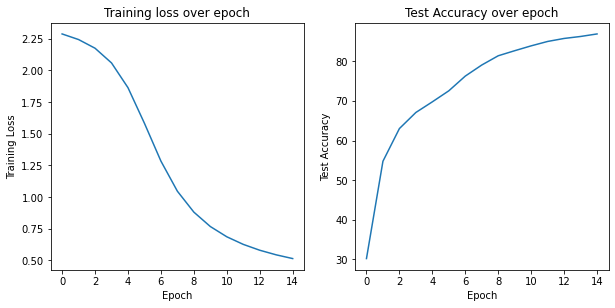

In [ ]:
import matplotlib.pyplot as plt

figure = plt.figure(figsize=(10,10))

f1 = figure.add_subplot(221)
f2 = figure.add_subplot(222)

epochs = range(num_epoch)

f1.plot(epochs, train_loss_epoch)
f1.set_title('Training loss over epoch')
f1.set_xlabel('Epoch')
f1.set_ylabel('Training Loss')


f2.plot(epochs, test_acc_epoch)
f2.set_title('Test Accuracy over epoch')
f2.set_xlabel('Epoch')
f2.set_ylabel('Test Accuracy')

plt.show()

## **Task 2) Implement and train a deep neural network with more layers**

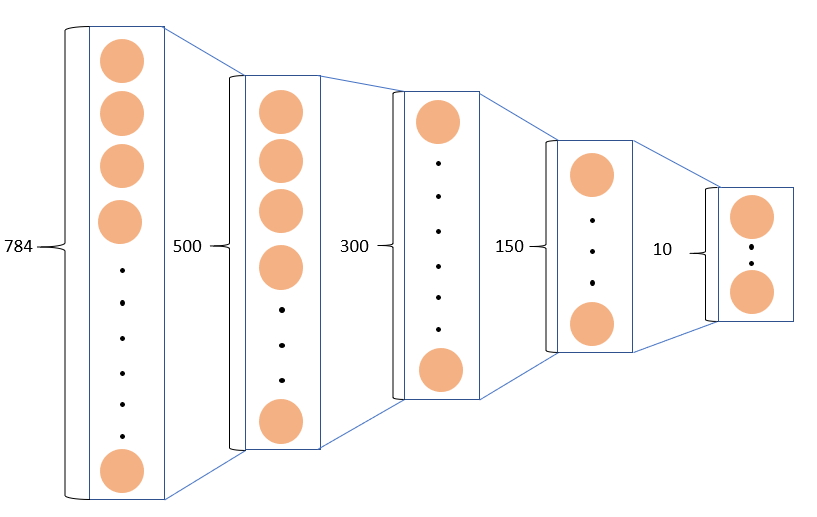

In this section, you will implement a more complicated deep neural network(See Figure above).

As compared to the model of task1, this model has 3 hidden layers with more parameters.

You should apply ReLU activation function at the output of each linear layer except for the output layer.

Refer to the Task1 and complete blanks in codeblocks below.


### **1. Defining our Model**


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class Deepernetwork(nn.Module):

    def __init__(self):

        super(Deepernetwork, self).__init__()
        # torch.nn.Linear(size of each input sample, size of each output sample)
        ################## Write your code here: Make 4 linear layers ####################
        self.fc1 = nn.Linear(784, 500) 
        self.fc2 = nn.Linear(500, 300) 
        self.fc3 = nn.Linear(300, 150) 
        self.fc4 = nn.Linear(150, 10) 
        ##################################################################################
    def forward(self, x):

        x = x.view(-1, 1*28*28) # Change the shape([batch_size, channels, row, col]) to [batch_size, channels*row*col] for fully-connected layer
        ################## Write your code here: Forward input x and return model ouput ####################
        x = F.relu(self.fc1(x)) 
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x) 
      ######################################################################################################
      
        return x


### **2. Training our Model**


In [ ]:
def train(model, device, train_loader, optimizer, criterion):
    model.train() # training mode 
    losses_batch = []

    ################## Write your code here: Compute loss and update model parameters ####################
    ####### Actually, you can copy the code of Task1, but try to understand typing on your own. ##########
    for idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device) #Move data to gpu if we can use gpu
        optimizer.zero_grad() # clear out the gradients to avoid accumulating with the gradients computed in previous step. 
        outputs = model(inputs) # 1) Proceed forward pass
        loss = criterion(outputs, labels) # 2) Compute the loss by comparing the predictive outputs and the actual labels
        losses_batch.append(loss)
        loss.backward() # 3) Compute a gradient of a loss function by backpropagation
        optimizer.step() # 4) Update the weight by gradient descent according to the method(SGD or SGD with momentum or Adam) we defined earlier

    loss_epoch = sum(losses_batch)/len(losses_batch)
    ######################################################################################################
    
    return loss_epoch

### **3. Evaluation of our Model**


In [ ]:
def eval(model, device, test_loader):
    model.eval() # evaluation mode
    total = 0
    correct = 0

    ################## Write your code here: Obtain prediction and corresponding accuracy. ###############
    ####### Actually, you can copy the code of Task1, but try to understand typing on your own. ##########
    with torch.no_grad(): # Deactivate the autograd engine # Note that in testing time, we don't need the gradient.
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device) #Move data to gpu if we can use gpu
            outputs = model(inputs) # Obtain the outputs from model
            _, predicts = torch.max(outputs.data , 1) # Make a prediction 
            total += labels.size(0)
            correct += (predicts==labels).sum().item() # Compute the number of correct predictions
    
    Accuracy = 100*correct/total
    ######################################################################################################  

    print('Test Accuracy: {:.2f}%'.format(Accuracy))
    return Accuracy

### **4. Check your code**

In [ ]:
# train and evaluate your model
torch.manual_seed(2020) # Sets the seed for reproducibility

model2 = Deepernetwork()
model2.to(device) # Move our model to gpu if we can use gpu

#Set the epoch
num_epoch = 15

#Determine the type of loss
criterion = nn.CrossEntropyLoss()

#Choose an optimizer for you to use and set learning rate
optimizer = optim.SGD(model2.parameters(), lr=0.001)

train_loss_epoch = []
test_acc_epoch = []

for epoch in tqdm(range(num_epoch)):
    train_loss_epoch.append(train(model2, device, train_loader, optimizer, criterion))
    test_acc_epoch.append(eval(model2, device, test_loader))

  7%|▋         | 1/15 [00:05<01:20,  5.77s/it]

Test Accuracy: 10.18%


 13%|█▎        | 2/15 [00:11<01:14,  5.76s/it]

Test Accuracy: 24.22%


 20%|██        | 3/15 [00:17<01:08,  5.72s/it]

Test Accuracy: 40.12%


 27%|██▋       | 4/15 [00:22<01:02,  5.72s/it]

Test Accuracy: 46.04%


 33%|███▎      | 5/15 [00:28<00:57,  5.71s/it]

Test Accuracy: 51.46%


 40%|████      | 6/15 [00:34<00:51,  5.70s/it]

Test Accuracy: 56.31%


 47%|████▋     | 7/15 [00:39<00:45,  5.68s/it]

Test Accuracy: 57.55%


 53%|█████▎    | 8/15 [00:45<00:39,  5.71s/it]

Test Accuracy: 58.37%


 60%|██████    | 9/15 [00:51<00:34,  5.68s/it]

Test Accuracy: 61.22%


 67%|██████▋   | 10/15 [00:56<00:28,  5.66s/it]

Test Accuracy: 66.99%


 73%|███████▎  | 11/15 [01:02<00:22,  5.65s/it]

Test Accuracy: 71.73%


 80%|████████  | 12/15 [01:08<00:16,  5.64s/it]

Test Accuracy: 74.59%


 87%|████████▋ | 13/15 [01:13<00:11,  5.62s/it]

Test Accuracy: 76.57%


 93%|█████████▎| 14/15 [01:19<00:05,  5.59s/it]

Test Accuracy: 78.08%


100%|██████████| 15/15 [01:24<00:00,  5.66s/it]

Test Accuracy: 79.82%


# **Optional Tasks**

### (Optional) Task 1 : Use different optimizers (e.g., SGD with momentum, Adam) and check the results


In [ ]:
#SGD with momentum

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_momentum = Mynetwork()
model_momentum.to(device)

num_epoch = 15


criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_momentum.parameters(), lr=0.001, momentum=0.9)


train_loss_epoch_momentum = []
test_acc_epoch_momentum = []


for epoch in tqdm(range(num_epoch)):
    train_loss_epoch_momentum.append(train(model_momentum, device, train_loader, optimizer, criterion))
    test_acc_epoch_momentum.append(eval(model_momentum, device, test_loader))

  7%|▋         | 1/15 [00:05<01:19,  5.70s/it]

Test Accuracy: 82.80%


 13%|█▎        | 2/15 [00:11<01:14,  5.71s/it]

Test Accuracy: 88.39%


 20%|██        | 3/15 [00:17<01:08,  5.69s/it]

Test Accuracy: 90.01%


 27%|██▋       | 4/15 [00:22<01:02,  5.70s/it]

Test Accuracy: 91.01%


 33%|███▎      | 5/15 [00:28<00:57,  5.71s/it]

Test Accuracy: 91.88%


 40%|████      | 6/15 [00:34<00:51,  5.69s/it]

Test Accuracy: 92.30%


 47%|████▋     | 7/15 [00:39<00:45,  5.69s/it]

Test Accuracy: 92.86%


 53%|█████▎    | 8/15 [00:45<00:39,  5.67s/it]

Test Accuracy: 93.26%


 60%|██████    | 9/15 [00:51<00:33,  5.66s/it]

Test Accuracy: 93.66%


 67%|██████▋   | 10/15 [00:56<00:28,  5.65s/it]

Test Accuracy: 93.94%


 73%|███████▎  | 11/15 [01:02<00:22,  5.66s/it]

Test Accuracy: 94.14%


 80%|████████  | 12/15 [01:08<00:17,  5.68s/it]

Test Accuracy: 94.54%


 87%|████████▋ | 13/15 [01:13<00:11,  5.67s/it]

Test Accuracy: 94.78%


 93%|█████████▎| 14/15 [01:19<00:05,  5.67s/it]

Test Accuracy: 95.04%


100%|██████████| 15/15 [01:25<00:00,  5.67s/it]

Test Accuracy: 95.19%


In [ ]:
#Adam

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_Adam = Mynetwork()
model_Adam.to(device)

num_epoch = 15

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_Adam.parameters(), lr=0.001, betas=(0.9,0.999))


train_loss_epoch_Adam = []
test_acc_epoch_Adam = []


for epoch in tqdm(range(num_epoch)):
    train_loss_epoch_Adam.append(train(model_Adam, device, train_loader, optimizer, criterion))
    test_acc_epoch_Adam.append(eval(model_Adam, device, test_loader))

  7%|▋         | 1/15 [00:06<01:25,  6.13s/it]

Test Accuracy: 96.64%


 13%|█▎        | 2/15 [00:12<01:19,  6.09s/it]

Test Accuracy: 97.12%


 20%|██        | 3/15 [00:18<01:12,  6.05s/it]

Test Accuracy: 97.19%


 27%|██▋       | 4/15 [00:24<01:06,  6.02s/it]

Test Accuracy: 97.85%


 33%|███▎      | 5/15 [00:30<01:00,  6.03s/it]

Test Accuracy: 98.07%


 40%|████      | 6/15 [00:36<00:54,  6.00s/it]

Test Accuracy: 97.77%


 47%|████▋     | 7/15 [00:41<00:47,  5.99s/it]

Test Accuracy: 98.17%


 53%|█████▎    | 8/15 [00:47<00:41,  5.99s/it]

Test Accuracy: 97.94%


 60%|██████    | 9/15 [00:53<00:35,  5.99s/it]

Test Accuracy: 98.16%


 67%|██████▋   | 10/15 [00:59<00:30,  6.00s/it]

Test Accuracy: 97.92%


 73%|███████▎  | 11/15 [01:06<00:24,  6.01s/it]

Test Accuracy: 98.11%


 80%|████████  | 12/15 [01:11<00:17,  6.00s/it]

Test Accuracy: 98.08%


 87%|████████▋ | 13/15 [01:18<00:12,  6.00s/it]

Test Accuracy: 98.26%


 93%|█████████▎| 14/15 [01:24<00:06,  6.05s/it]

Test Accuracy: 98.14%


100%|██████████| 15/15 [01:30<00:00,  6.02s/it]

Test Accuracy: 97.85%


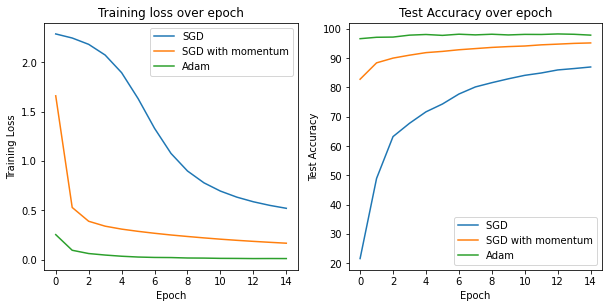

In [ ]:
figure = plt.figure(figsize=(10,10))

f1 = figure.add_subplot(221)
f2 = figure.add_subplot(222)

epochs = range(num_epoch)

f1.plot(epochs, train_loss_epoch[:15], label='SGD')
f1.plot(epochs, train_loss_epoch_momentum, label='SGD with momentum')
f1.plot(epochs, train_loss_epoch_Adam, label='Adam')
f1.legend()
f1.set_title('Training loss over epoch')
f1.set_xlabel('Epoch')
f1.set_ylabel('Training Loss')

f2.plot(epochs, test_acc_epoch[:15],  label='SGD ')
f2.plot(epochs, test_acc_epoch_momentum,  label='SGD with momentum')
f2.plot(epochs, test_acc_epoch_Adam,  label='Adam')
f2.legend()
f2.set_title('Test Accuracy over epoch')
f2.set_xlabel('Epoch')
f2.set_ylabel('Test Accuracy')

plt.show()

### (Optional) Task 2 : Preventing Overfit: Regularization Techniques

#### 1.Weight Decay - L2 (Ridge) regularization

In [ ]:
#L2 (Ridge) regularization

model_L2 = Mynetwork()
model_L2.to(device)

num_epoch = 15

device = 'cuda' if torch.cuda.is_available() else 'cpu'

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_L2.parameters(), lr=0.001, weight_decay=0.05) # we can add L2 regularization effect by giving a weight decay parameter(lambda)


train_loss_epoch_L2 = []
test_acc_epoch_L2 = []


for epoch in tqdm(range(num_epoch)):
    train_loss_epoch_L2.append(train(model_L2, device, train_loader, optimizer, criterion))
    test_acc_epoch_L2.append(eval(model_L2, device, test_loader))

  7%|▋         | 1/15 [00:05<01:20,  5.78s/it]

Test Accuracy: 23.01%


 13%|█▎        | 2/15 [00:11<01:14,  5.76s/it]

Test Accuracy: 46.10%


 20%|██        | 3/15 [00:17<01:09,  5.76s/it]

Test Accuracy: 57.40%


 27%|██▋       | 4/15 [00:22<01:03,  5.75s/it]

Test Accuracy: 61.33%


 33%|███▎      | 5/15 [00:28<00:57,  5.76s/it]

Test Accuracy: 63.01%


 40%|████      | 6/15 [00:34<00:51,  5.75s/it]

Test Accuracy: 64.96%


 47%|████▋     | 7/15 [00:40<00:45,  5.74s/it]

Test Accuracy: 67.32%


 53%|█████▎    | 8/15 [00:45<00:40,  5.73s/it]

Test Accuracy: 69.46%


 60%|██████    | 9/15 [00:51<00:34,  5.71s/it]

Test Accuracy: 70.59%


 67%|██████▋   | 10/15 [00:57<00:28,  5.70s/it]

Test Accuracy: 71.81%


 73%|███████▎  | 11/15 [01:02<00:22,  5.71s/it]

Test Accuracy: 73.66%


 80%|████████  | 12/15 [01:08<00:17,  5.72s/it]

Test Accuracy: 74.85%


 87%|████████▋ | 13/15 [01:14<00:11,  5.70s/it]

Test Accuracy: 75.87%


 93%|█████████▎| 14/15 [01:20<00:05,  5.70s/it]

Test Accuracy: 77.03%


100%|██████████| 15/15 [01:25<00:00,  5.72s/it]

Test Accuracy: 78.05%


#### 2.Dropout

In [ ]:
#Dropout

class Mynetwork_dropout(nn.Module):

    def __init__(self):

        super(Mynetwork_dropout, self).__init__()
        # torch.nn.Linear(size of each input sample, size of each output sample)
        self.fc1 = nn.Linear(784,390) 
        self.fc2 = nn.Linear(390, 200) 
        self.fc3 = nn.Linear(200, 10) 
        self.dropout = nn.Dropout(p=0.2) # During training, randomly zeroes some of the elements of the input tensor with probability p using samples from a Bernoulli distribution


    def forward(self, x):

        x = x.view(-1, 1*28*28) # Change the shape([batch_size, channels, row, col]) to [batch_size, channels*row*col] for fully-connected layer
        x = F.relu(self.fc1(x)) # Use relu function after fully-connected layer
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = self.fc3(x) # Softmax function is not applied here.

        return x

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_dropout = Mynetwork_dropout()
model_dropout.to(device)

num_epoch = 15



criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model_dropout.parameters(), lr=0.001, weight_decay=0.05)


train_loss_epoch_DO = []
test_acc_epoch_DO = []


for epoch in tqdm(range(num_epoch)):
    train_loss_epoch_DO.append(train(model_dropout, device, train_loader, optimizer, criterion))
    test_acc_epoch_DO.append(eval(model_dropout, device, test_loader))

  7%|▋         | 1/15 [00:05<01:22,  5.87s/it]

Test Accuracy: 23.37%


 13%|█▎        | 2/15 [00:11<01:16,  5.86s/it]

Test Accuracy: 39.79%


 20%|██        | 3/15 [00:17<01:09,  5.83s/it]

Test Accuracy: 54.19%


 27%|██▋       | 4/15 [00:23<01:04,  5.83s/it]

Test Accuracy: 60.06%


 33%|███▎      | 5/15 [00:29<00:58,  5.82s/it]

Test Accuracy: 62.20%


 40%|████      | 6/15 [00:34<00:52,  5.81s/it]

Test Accuracy: 62.80%


 47%|████▋     | 7/15 [00:40<00:46,  5.81s/it]

Test Accuracy: 64.22%


 53%|█████▎    | 8/15 [00:46<00:40,  5.81s/it]

Test Accuracy: 66.04%


 60%|██████    | 9/15 [00:52<00:34,  5.81s/it]

Test Accuracy: 67.75%


 67%|██████▋   | 10/15 [00:58<00:29,  5.81s/it]

Test Accuracy: 69.13%


 73%|███████▎  | 11/15 [01:03<00:23,  5.80s/it]

Test Accuracy: 70.91%


 80%|████████  | 12/15 [01:09<00:17,  5.78s/it]

Test Accuracy: 73.31%


 87%|████████▋ | 13/15 [01:15<00:11,  5.76s/it]

Test Accuracy: 74.94%


 93%|█████████▎| 14/15 [01:21<00:05,  5.75s/it]

Test Accuracy: 76.53%


100%|██████████| 15/15 [01:26<00:00,  5.79s/it]

Test Accuracy: 77.45%


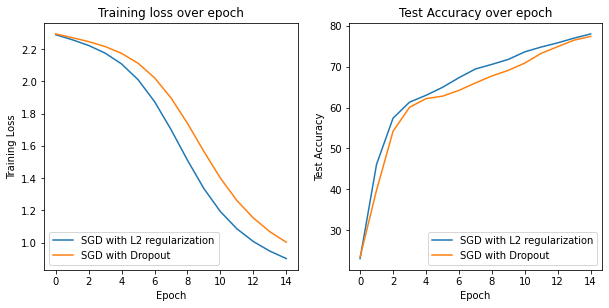

In [ ]:
figure = plt.figure(figsize=(10,10))

f1 = figure.add_subplot(221)
f2 = figure.add_subplot(222)

epochs = range(num_epoch)

f1.plot(epochs, train_loss_epoch_L2, label='SGD with L2 regularization')
f1.plot(epochs, train_loss_epoch_DO, label='SGD with Dropout')

f1.legend()
f1.set_title('Training loss over epoch')
f1.set_xlabel('Epoch')
f1.set_ylabel('Training Loss')

f2.plot(epochs, test_acc_epoch_L2,  label='SGD with L2 regularization')
f2.plot(epochs, test_acc_epoch_DO,  label='SGD with Dropout')

f2.legend()
f2.set_title('Test Accuracy over epoch')
f2.set_xlabel('Epoch')
f2.set_ylabel('Test Accuracy')

plt.show()

### (Optional) Task 3 : Applying Batch Normalization
 - During backpropagation, unfornuately, gradient may vanish or explode.
 - You can use batch normalization to stablize the distribution of output of each layer.

 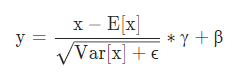


- The mean E\[x] and variance Var\[x] are calculated per-dimension oer the mini-batches and $\gamma$ and $\beta$ are learnable parameter.
- You can use **torch.nn.Batchnorm1d(num_feature, ...)** to apply batch normalization.

In [ ]:
import torch.nn as nn
import torch.nn.functional as F

class BatchNormNet(nn.Module):

    def __init__(self):

        super(BatchNormNet, self).__init__()
        # torch.nn.Linear(size of each input sample, size of each output sample)
        self.fc1 = nn.Linear(784,390) # Input size should be 784 (28*28*1) and output size is the size of first hidden layer(your design parameter).
        self.fc2 = nn.Linear(390, 200) # Input size should be the size of first hidden layer and output size is the size of second hidden layer(your design parameter).
        self.fc3 = nn.Linear(200, 10) # Input size should be the size of second hidden layer and output size should be 10 (the number of classes).
        self.bn1 = nn.BatchNorm1d(num_features=390)
        self.bn2 = nn.BatchNorm1d(num_features=200)

    def forward(self, x):

        x = x.view(-1, 1*28*28) # Change the shape([batch_size, channels, row, col]) to [batch_size, channels*row*col] for fully-connected layer
        x = F.relu(self.bn1(self.fc1(x))) # Use relu function after fully-connected layer
        x = F.relu(self.bn2(self.fc2(x)))
        x = self.fc3(x) # Note that softmax function is not applied here.

        return x

In [ ]:
# train and evaluate your model

model_bn = BatchNormNet()
model_bn.to(device)
#Choose an optimizer for you to use and set learning rate
optimizer = optim.SGD(model_bn.parameters(), lr=0.001)

train_loss_epoch = []
test_acc_epoch = []

for epoch in tqdm(range(num_epoch)):
    train_loss_epoch.append(train(model_bn, device, train_loader, optimizer, criterion))
    test_acc_epoch.append(eval(model_bn, device, test_loader))

  7%|▋         | 1/15 [00:05<01:23,  5.97s/it]

Test Accuracy: 87.71%


 13%|█▎        | 2/15 [00:11<01:17,  5.97s/it]

Test Accuracy: 90.69%


 20%|██        | 3/15 [00:17<01:11,  5.98s/it]

Test Accuracy: 92.05%


 27%|██▋       | 4/15 [00:23<01:05,  5.97s/it]

Test Accuracy: 92.96%


 33%|███▎      | 5/15 [00:29<00:59,  5.98s/it]

Test Accuracy: 93.53%


 40%|████      | 6/15 [00:36<00:54,  6.02s/it]

Test Accuracy: 93.80%


 47%|████▋     | 7/15 [00:42<00:48,  6.05s/it]

Test Accuracy: 94.36%


 53%|█████▎    | 8/15 [00:48<00:42,  6.02s/it]

Test Accuracy: 94.60%


 60%|██████    | 9/15 [00:54<00:36,  6.02s/it]

Test Accuracy: 94.85%


 67%|██████▋   | 10/15 [01:00<00:30,  6.01s/it]

Test Accuracy: 95.13%


 73%|███████▎  | 11/15 [01:06<00:24,  6.00s/it]

Test Accuracy: 95.40%


 80%|████████  | 12/15 [01:12<00:17,  5.99s/it]

Test Accuracy: 95.41%


 87%|████████▋ | 13/15 [01:17<00:11,  5.98s/it]

Test Accuracy: 95.61%


 93%|█████████▎| 14/15 [01:23<00:05,  5.96s/it]

Test Accuracy: 95.71%


100%|██████████| 15/15 [01:29<00:00,  5.99s/it]

Test Accuracy: 96.05%


## 6. Reference
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html?highlight=dataset%20dataloader

https://wikidocs.net/57165

https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/